In [27]:
import numpy as np
import pandas as pd
import auxil_ML as aux
from matplotlib import pyplot
import os

import plotting

In [28]:
algs = ['RF', 'LR', 'BDT', 'NN']
algs_O = ['%s_O' % alg for alg in algs]
algs_all = algs + algs_O


def get_prec_recall(cat, n, thresholds, label='PSR', condition='all'):
    df = cat_dfs[cat][n]
    cat_ = cat.split('-')[0]
    assoc_mask = df['Category_%s' % cat_] != 'UNAS'
    true_mask = df['Category_%s' % cat_] == label
    true_mask &= assoc_mask
    res_dict = {}
    res_dict['prec'] = np.zeros_like(thresholds)
    res_dict['recall'] = np.zeros_like(thresholds)
    res_dict['true_positive'] = np.zeros_like(thresholds)
    res_dict['positive'] = np.zeros_like(thresholds)
    res_dict['true'] = np.zeros_like(thresholds)
    cols = ['%s_%s' % (label, alg) for alg in algs_all]
    for i, thres in enumerate(thresholds):
        if condition == 'all':
            positive_mask = np.prod(df[cols] >= thres, axis=1).astype(bool)
        elif condition == 'sum':
            positive_mask = (np.mean(df[cols], axis=1) >= thres).astype(bool)
        positive_mask &= assoc_mask
        res_dict['true_positive'][i] = np.sum(true_mask & positive_mask)
        res_dict['positive'][i] = np.sum(positive_mask)
        res_dict['true'][i] = np.sum(true_mask)
        # precision = true positive / positive
        positive = np.maximum(res_dict['positive'][i], eps)
        res_dict['prec'][i] = res_dict['true_positive'][i] / positive
        # recall = true positive / true
        res_dict['recall'][i] = res_dict['true_positive'][i] / res_dict['true'][i]
    
    return res_dict

eps = 1.e-15

def get_prec_recall_3vs4(cat_dfs, n, thresholds, index_4fgl, label='PSR', condition='all'):
    cat_df_4fgl = cat_dfs['4FGL-DR2'][n].loc[index_4fgl]
    # unassociated sources in 3FGL, which have associations in 4FGL
    index_3fgl = list(cat_df_4fgl['ASSOC_FGL'].loc[index_4fgl])
    cat_df_3fgl = cat_dfs['3FGL'][n].loc[index_3fgl]
    true_mask = np.array(cat_df_4fgl['Category_4FGL'] == label)
    res_dict = {}
    res_dict['prec'] = np.zeros_like(thresholds)
    res_dict['recall'] = np.zeros_like(thresholds)
    res_dict['true_positive'] = np.zeros_like(thresholds)
    res_dict['positive'] = np.zeros_like(thresholds)
    res_dict['true'] = np.zeros_like(thresholds)
    cols = ['%s_%s' % (label, alg) for alg in algs_all]
    for i, thres in enumerate(thresholds):
        
        if condition == 'all':
            positive_mask = np.prod(cat_df_3fgl[cols] >= thres, axis=1).astype(bool)
        elif condition == 'sum':
            positive_mask = (np.mean(cat_df_3fgl[cols], axis=1) >= thres).astype(bool)

        if label == 'PSR' and n == 3 and 0:
            print(len(true_mask))
            print(positive_mask)
        res_dict['true_positive'][i] = np.sum(true_mask & positive_mask)
        res_dict['positive'][i] = np.sum(positive_mask)
        res_dict['true'][i] = np.sum(true_mask)
        # precision = true positive / positive
        positive = np.maximum(res_dict['positive'][i], eps)
        res_dict['prec'][i] = res_dict['true_positive'][i] / positive
        # recall = true positive / true
        res_dict['recall'][i] = res_dict['true_positive'][i] / res_dict['true'][i]
    
    return res_dict

In [29]:
cat_dfs = {}
cats = ['3FGL', '4FGL-DR2']
# initialize the dictionary of catalogs
for cat in cats:
    cat_dfs[cat] = {}

# load dictionaries
for cat in cats:
    cat_dfs[cat] = {}
    for n in [2, 3]:
        cat_fn = '../SOM/%s_prob_catalog_%iclasses.csv' % (cat, n)
        cat_dfs[cat][n] = pd.read_csv(cat_fn, index_col=0)


In [30]:
# find all associated sources in 4FGL, which are also associated to unassociated 3FGL sources
cat_df_4fgl = cat_dfs['4FGL-DR2'][2]
cat_df_3fgl = cat_dfs['3FGL'][2]
assoc_3FGL_in_4FGL_mask = [(type(name) is str) for name in list(cat_df_4fgl['ASSOC_FGL'])]
index0 = [name for name in cat_df_4fgl.index[assoc_3FGL_in_4FGL_mask] 
         if cat_df_4fgl['ASSOC_FGL'].loc[name].startswith('3FGL') 
         and cat_df_4fgl['ASSOC_FGL'].loc[name] in cat_df_3fgl.index
         and cat_df_3fgl['Category_3FGL'].loc[cat_df_4fgl['ASSOC_FGL'].loc[name]] == 'UNAS']

# subselect sources, which are associated
index_4fgl = [name for name in index0 if cat_df_4fgl['Category_4FGL'].loc[name] != 'UNAS']
print(len(index_4fgl))

340


In [31]:
cat = '3FGL' # '3FGL', '4FGL-DR2'
label = 'PSR' # 'PSR', 'OTHER'
test = 1

if test:
    conds = ['all', 'sum']
else:
    conds = ['all']

thresholds = np.arange(0.1, 0.92, 0.03)
#thresholds = np.arange(0.1, 0.92, 0.1)
if label == 'OTHER':
    ncl = [3]
else:
    ncl = [3, 2]
plotting.setup_figure_pars();

save_plots = 0
ls_dict = {'prec':{2:'-.', 3:'-'}, 'recall':{2:':', 3:'--'}}
#plots_folder = 'plots/thresholds'
plots_folder = '../ML_3FGL_paper/plots/thresholds/'
if not os.path.isdir(plots_folder):
    os.makedirs(plots_folder)

3 [204. 190. 178. 170. 162. 152. 146. 136. 126. 123. 120. 116. 112. 105.
  95.  93.  92.  86.  82.  74.  63.  57.  50.  44.  33.  23.   7.   2.]
2 [230. 216. 207. 201. 193. 187. 183. 178. 174. 169. 161. 158. 152. 145.
 138. 134. 130. 125. 122. 116. 107. 102.  97.  93.  84.  80.  73.  57.]


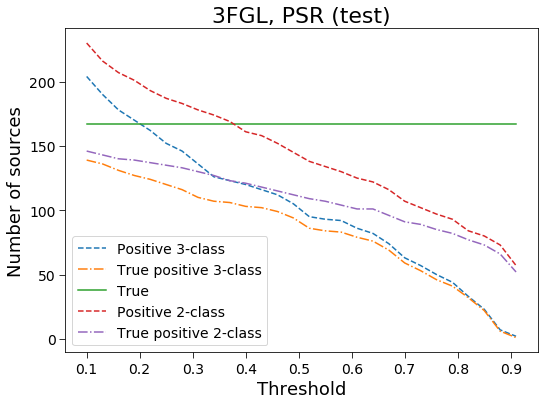

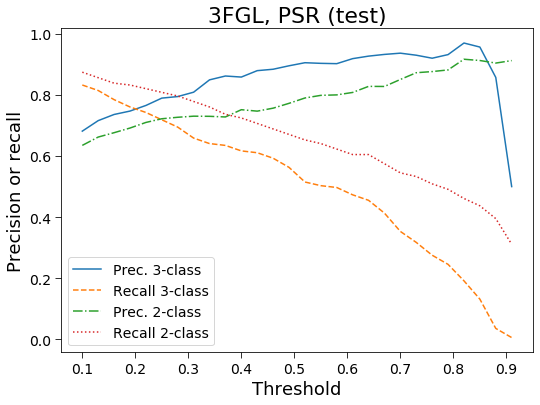

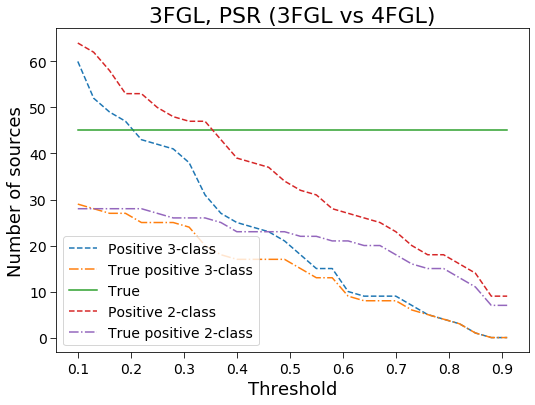

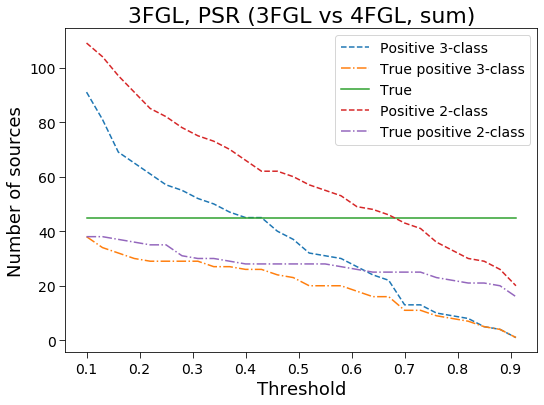

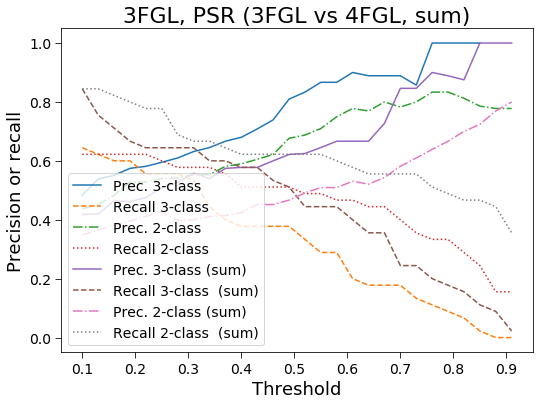

In [32]:
pyplot.figure()
for n in ncl:
    res_dict = get_prec_recall(cat, n, thresholds, label=label)
    print(n, res_dict['positive'])
    if n == 2:
        pyplot.plot(thresholds, res_dict['true'], ls='-', 
                    label='True')
    pyplot.plot(thresholds, res_dict['positive'], ls='--', 
                label='Positive %i-class' % n)
    pyplot.plot(thresholds, res_dict['true_positive'], ls='-.', 
                label='True positive %i-class' % n)
pyplot.xlabel('Threshold')
pyplot.ylabel('Number of sources')
pyplot.legend()
pyplot.title('%s, %s (test)' % (cat, label))
 
pyplot.figure()
for n in ncl:
    res_dict = get_prec_recall(cat, n, thresholds, label=label)
    zero_mask = res_dict['positive'] == 0
    pyplot.plot(thresholds[~zero_mask], res_dict['prec'][~zero_mask], 
                ls=ls_dict['prec'][n], label='Prec. %i-class' % n)
    pyplot.plot(thresholds, res_dict['recall'], 
                ls=ls_dict['recall'][n], label='Recall %i-class' % n)
pyplot.xlabel('Threshold')
pyplot.ylabel('Precision or recall')
pyplot.legend()
pyplot.title('%s, %s (test)' % (cat, label))
if save_plots:
    fn = '%s/thresholds_prec_recall_%s_%s.pdf' % (plots_folder, cat, label)
    print('save figure to file: %s' % fn)
    pyplot.savefig(fn)

if cat == '3FGL':
    for cond in conds:
        pyplot.figure()
        for n in ncl:
            res_dict = get_prec_recall_3vs4(cat_dfs, n, thresholds, index_4fgl, label=label, condition=cond)
            if n == 2:
                pyplot.plot(thresholds, res_dict['true'], ls='-', 
                            label='True')
            pyplot.plot(thresholds, res_dict['positive'], ls='--', 
                        label='Positive %i-class' % n)
            pyplot.plot(thresholds, res_dict['true_positive'], ls='-.', 
                        label='True positive %i-class' % n)
        pyplot.xlabel('Threshold')
        pyplot.ylabel('Number of sources')
        pyplot.legend()
        if cond == 'all':
            pyplot.title('%s, %s (3FGL vs 4FGL)' % (cat, label))
        else:
            pyplot.title('%s, %s (3FGL vs 4FGL, sum)' % (cat, label))
            
    for cond in conds:
        if cond == 'all':
            pyplot.figure()
        for n in ncl:
            res_dict = get_prec_recall_3vs4(cat_dfs, n, thresholds, index_4fgl, label=label, condition=cond)
            zero_mask = res_dict['positive'] == 0
            lbl='Prec. %i-class' % n
            if cond == 'sum':
                lbl += ' (sum)'
            pyplot.plot(thresholds[~zero_mask], res_dict['prec'][~zero_mask], 
                        ls=ls_dict['prec'][n], label=lbl)
            lbl = 'Recall %i-class ' % n
            if cond == 'sum':
                lbl += ' (sum)'
            pyplot.plot(thresholds, res_dict['recall'], ls=ls_dict['recall'][n],
                        label=lbl)
        pyplot.xlabel('Threshold')
        pyplot.ylabel('Precision or recall')
        pyplot.legend()
        if cond == 'all':
            pyplot.title('%s, %s (3FGL vs 4FGL)' % (cat, label))
        else:
            pyplot.title('%s, %s (3FGL vs 4FGL, sum)' % (cat, label))
            
        if save_plots:
            fn = '%s/thresholds_prec_recall_3FGL_vs_4FGL-DR2_%s.pdf' % (plots_folder, label)
            print('save figure to file: %s' % fn)
            pyplot.savefig(fn)



In [33]:
# test precision and recall for all agree methods in the 2-class case: Tables 4 and 7
# the 3-class classification uses max prob. instead of thresholds!
print('All agree method')
thrs = [0.5]
labels = ['AGN', 'PSR', 'OTHER']
n = 2
for cat in ['3FGL', '4FGL-DR2']:
    for label in labels:
        if label != 'OTHER' or n == 3:
            res_dict = get_prec_recall(cat, n, thrs, label=label)
            print('%s, %i, %s, prec: %.2f' % (cat, n, label, res_dict['prec']))
            print('%s, %i, %s, recall: %.2f' % (cat, n, label, res_dict['recall']))

All agree method
3FGL, 2, AGN, prec: 0.97
3FGL, 2, AGN, recall: 0.94
3FGL, 2, PSR, prec: 0.78
3FGL, 2, PSR, recall: 0.67
4FGL-DR2, 2, AGN, prec: 0.96
4FGL-DR2, 2, AGN, recall: 0.95
4FGL-DR2, 2, PSR, prec: 0.71
4FGL-DR2, 2, PSR, recall: 0.70


In [34]:
# test the precision and recall: compare with numbers in table 4
print('3FGL vs 4FGL-DR2 method')
thrs = [0.5]
labels = ['AGN', 'PSR']
cat = '3FGL'
n = 2
for label in labels:
    res_dict = get_prec_recall_3vs4(cat_dfs, n, thrs, index_4fgl, label=label)
    print('%s, %i, %s, prec: %.2f' % (cat, n, label, res_dict['prec']))
    print('   tp: %.2f, p: %.2f' % (res_dict['true_positive'], res_dict['positive']))
    print('%s, %i, %s, recall: %.2f' % (cat, n, label, res_dict['recall']))

3FGL vs 4FGL-DR2 method
3FGL, 2, AGN, prec: 0.93
   tp: 223.00, p: 241.00
3FGL, 2, AGN, recall: 0.86
3FGL, 2, PSR, prec: 0.68
   tp: 23.00, p: 34.00
3FGL, 2, PSR, recall: 0.51
